# Microscopy

<hr>

Objectives:
- Learn to analyze imaging data from microscopy.
- Learn how to use AI methods for microscopy at the example of image segmentation for bacteria.

## Optical Microscopy

Optical microscopes use an optical system of lenses and visible light to generate a magnified image of a sample. The maximum attainable magnification in current setups, due to physical limitations, is about 1000x. While other microscopy techniques with higher magnification exist, our use-cases typically require that the sample, e.g., a bacterial culture, can proliferate while being observed. This is currently not the case with methods like [atomic force microscopy (AFM)](https://en.wikipedia.org/wiki/Atomic_force_microscopy) and [electron microscopy](https://en.wikipedia.org/wiki/Electron_microscope).

## Image processing problems
When working with microscopy data, we usually begin with a stack of images.
Such images can be without a time-component, or snapshots of a process taken over time.

While all relevant information is within these images, we want to extract more abstract properties.
For example, we may see a bacteria moving from the left to the right, duplicating in the middle of its travel.
The abstract information that we will extract depends on the research question.
In this case, we may for example, be interested in the number and positions of all bacteria in this image.
This can then be more easily be further abstracted into, e.g., statistics about the interaction of bacteria and their single-cell
growth rates.

The main computational tasks can be grouped as follows:
- Label: Detect the presence of particular objects in an image.
- Segment: Additionally, detect the position of the objects, e.g., via a bounding box or at the pixel-level (segmentation).
- Track: Additionally, track the objects along the sequence of images.

## Image data in Python

Images are functions that assign a pixel a value.
In Python, microscopy images are usually represented as NumPy arrays of type `np.ndarray`.
The dimensionality of this array may vary, depending on the information that is stored in them.
The simplest case is a 2-dimensional array of the shape (H, W) with H being the height and W being the width of the image in pixels.

A simple gray-scale image in numpy is

In [ ]:
import numpy as np

H, W = 4, 4
img = np.zeros([H, W], dtype='int64')
img[0,0] = 1.0

print(img)

where all pixels of the 4x4 image are black (= 0) and the top-left pixel has value 1.
Without referring to a colormap that assigns values to colors, we cannot say as which color the 1 will show up the image.

We can view this image, e.g., with `matplotlib` by calling and using the `gray` that shows tones of gray between 0 and 1.
In this colormap, the 1 will be thus white.

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img, cmap='gray')

With color map `jet` we would have gotten a different picture.

In [ ]:
plt.imshow(img, cmap='jet')

### RGB vs grayscale shapes
A single-channel grayscale image typically has array-shape `(H, W)` where each pixel contains one intensity value, as we have seen before.
An RGB image adds a third dimension for color channels `(H, W, 3)` representing red, green, and blue intensities.
To unify the treatment of grayscale and RGB images, some libraries expect all images to have 3 dimensions.
In this case, a grayscale image is not a 2-D array `(H, W)`, but a 3-D array `(H, W, 1)`; the latter simply adds an explicit channel dimension, which an be created with `image[..., None]` or `np.expand_dims(image, axis=-1)`.

Let us create an RGB image with a red pixel at the top.

In [ ]:
H, W, C = 4, 4, 3
img_rgb = np.zeros([H, W, C], dtype='int64')
img_rgb[0,0,:] = (255, 0, 0)  # (red, green, blue) from 0 to 255 -> pure red

plt.imshow(img_rgb)

### Bit depth

In the previous images, we encoded values as `int64`. This is not necessarily always the case.
Image arrays come in different numeric types:

- `uint8` (0–255): Standard 8-bit grayscale or RGB images. 
- `int16` to `int64` and  `uint16` to `uint64`: Often used for discrete labeling masks, though some libraries support only certain bit depths, making conversions frequently necessary.
In microscopy, raw intensities can range far beyond 0–255, so larger bit-width images are common.
- `float16` / `float32`: Continuous values, often used after normalization, especially for neural networks.

### Normalization
For machine learning, intensities are often normalized, e.g.:

- to the range $[0, 1]$
- or other ranges like integers in 0-99 or 0-255

This ensures that the network sees well-behaved data rather than wildly varying raw intensities.
While some NN-based frameworks normalize images internally for training and inference, it is good practice to normalize before: you will be using several frameworks are once, some of which do not normalize automatically. Also make sure to check within which ranges your framework expects values.

### Channel ordering
Images may have multiple channels (e.g., 1 for grayscale, 3 for RGB, several for fluorescence channels).
Two common conventions are:

- `(H, W, C)` (height, width, channels): typical for NumPy and most PIL/OpenCV operations.
- `(C, H, W)`: used by PyTorch tensors.

Mixing these up is one of the most frequent sources of bugs in image pipelines.

### As tensors

When moving from NumPy to deep learning frameworks like PyTorch, images are converted to **tensors**:

```python
import torch
image_tensor = torch.from_numpy(image_np)
```
Opposed to NumPy arrays, tensors may carry gradient information.
The default channel order in PyTorch is `(C,H,W)` shape, so images often need to be transposed:
```python
image = image.transpose(2, 0, 1)  # HWC to CHW
```


## Segmentation
In this lecture, we will focus on the segmentation problem at the example of bacterial cells.

The problem is often encoded as an image file and the output as a mask file. Both in pixel-accurate formats like `.tif`.
There are two different encodings for masks.
- **Binary masks** treat all foreground pixels as one class (0 = background, 1 = cell) and are suited for simple semantic segmentation when distinguishing foreground from background is sufficient.
- **Instance masks** give each object a unique label (0 = background, 1 = cell1, 2 = cell2, ...) and are preferred when object-level separation and counting are required, such as in crowded bacterial colonies.

We will study both problems, generating a binary mask and instance masks.

## Idealized Microscopic Data

We will start with idealized images of objects like they would be expected from bacteria visualized by microscopy.
For the purpose of simplicity, we first assume that our bacteria are disk-shaped, but can potentially overlap.

Let's install some libraries first.

In [ ]:
# Install necessary packages

# %pip install scikit-image
# %pip install opencv-python
# %pip install torch
# %pip install albumentations
# %pip install segmentation-models-pytorch
# %pip install pytorch-lightning
# %pip install cellpose

Below is code for a simple canvas we can draw on.

In [ ]:
%%capture

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path

import skimage
from skimage.draw import disk

class Canvas:
    """A simple canvas to draw shapes on."""
    x: int
    y: int
    img: np.ndarray

    def __init__(self, x: int, y: int) -> None:
        """Create a canvas.
        x: width
        y: length
        """
        self.x = x
        self.y = y
        self.img = np.zeros([x, y], dtype='int64')

    def disk(self, x: int, y: int, r: int) -> None:
        """Draw a disk.
        x, y: center
        r: radius
        """
        rr, cc = disk((x, y), r)
        self.img[rr, cc] = 1
    
    def show(self) -> None:
        """Show the canvas."""
        plt.imshow(self.img, cmap='gray')


Let's draw some circles. For the sake of challenge, two of them will overlap.
This rules out the simple approach of considering each connected component as an object.

In [ ]:
c: Canvas = Canvas(100, 100)
c.disk(20, 20, 10)
c.disk(35, 35, 15)
c.disk(60, 60, 8)
c.show()

## Dealing with Overlaps: Distance Maxima and Watershedding

We now aim to perform an instance segmentation of this image. In particular, a so-called segmentation mask has the same dimensions as the original image, with each pixel value being the id of the object it belongs to.
The value 0 is reserved for the background.
In our case, 3 more values are to be assigned, 1, 2, and 3, corresponding to the 3 circle instances.

We solve this problem via a commonly used approach:
1. Generate a distance field to the background. The background is black and has value 0. Based on this, we assign each pixel a distance to the background.
2. Let the local maxima correspond to the centers of the objects.
3. Use the [Watershed algorithm](https://en.wikipedia.org/wiki/Watershed_(image_processing)) to assign the remaining pixels.

In [ ]:
from scipy import ndimage as ndi

# Compute distance to 0-valued background
distance: np.ndarray = ndi.distance_transform_edt(c.img)
assert isinstance(distance, np.ndarray), "ensure type"

# Show the distance field as a heatmap
plt.imshow(distance, cmap=plt.cm.jet);

We next use `peak_local_max(...)` to find local maxima. The function has a parameter that specifies the locality: `footprint (ndarray of bools)` that is a mask for the local region within which to search for peaks at every point in `image`.

In [ ]:
from skimage.segmentation import watershed
from skimage.feature import peak_local_max


def find_watershed(
        img: np.ndarray,
        min_distance: int=10,
        footprint: np.ndarray=np.ones((10,10))
    ) -> tuple[np.ndarray, int]:
    """Find watershed segmentation of an image.
    
    Arguments:
        img: input image (2D array)
        min_distance: minimum distance between local maxima
        footprint: search area for local maxima
    
    Returns:
        labels: segmentation labels of pixels
        num_features: number of detected features
    """
    
    # Compute distance to background (background has value 0)
    distance: np.ndarray = ndi.distance_transform_edt(img)
    assert isinstance(distance, np.ndarray), "ensure type"

    # Get local (within footprint) maxima of the distance field
    # filter via minimum distance between maxima
    coords = peak_local_max(distance, labels=img, min_distance=min_distance, footprint=footprint)

    # Create segmentation labels for pixels
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, num_features = ndi.label(mask)
    return watershed(-distance, markers, mask=img), num_features

labels, num_features = find_watershed(c.img)
plt.imshow(labels, cmap=plt.cm.nipy_spectral)
print("Number of cells:", num_features)

## Noise

Let's increase the difficulty by adding some noise.
Clearly the type of noise depends on the microscopy setup.
Cell debris, inhomogeneous illumination, and dist on the lense or the measurement setup are only a few examples.
For the sake of simplicity, we add random pixels as an idealized noise source.

The function `np.random.random(shape)` returns random floats of shape `shape`, with each pixel being uniformly random in $[0, 1)$.

By multiplying a random value for a pixel by a constant $c$ (here, 1.1) and casting it to an `int`, we obtain that a pixel is `1` with probability $c - 1$ (here, 0.1) and `0`, otherwise.

Using this value as additive noise, we obtain:

In [ ]:
img = c.img + (1.1 * np.random.random(c.img.shape)).astype("int64")
plt.imshow(img, cmap=plt.cm.gray);

Let us try the watershed algorithm directly on the noisy image.

In [ ]:
labels, num_features = find_watershed(img)
plt.imshow(labels, cmap=plt.cm.nipy_spectral)
print("Number of cells:", num_features)

The segmentation and the number of cells is clearly off.
All the single pixels are recognized as small cells.

We can do some image preprocessing to fix this.
One idea to remove small speckles is to erode them - letting the background grow into the object, and in a second step grow back the remaining objects.
The idea is that small speckles will be deleted in the first step, while large objects are almost not altered by the two consecutive steps.

In [ ]:
from scipy.ndimage import binary_erosion, binary_dilation

# shrink
img_new = binary_erosion(img, iterations=5)

# grow
img_new = binary_dilation(img_new, iterations=5)

plt.imshow(img_new, cmap=plt.cm.nipy_spectral);

It worked! All the speckles are gone. The objects have changed shape a bit, but this should not impede the watershed algorithm too much.

Let's try it on the preprocessed image.

In [ ]:
labels, num_features = find_watershed(img_new)
plt.imshow(labels, cmap=plt.cm.nipy_spectral)
print("Number of cells:", num_features)

Indeed, the segmentation is correct! We are ready for real data.

## Microscopic data of *E. coli*

We have uploaded an image of *E. coli* that we took in our lab with a microfluidic setup, an inverted microscope (40x lense), and a Raspberry Pi + camera.
The image `data/ecoli.png` is a crop of this image showing 3 bacteria.

The length of an *E. coli* is roughly 2 um, giving us a rough idea of the size of the crop as about 15 um x 15 um.

Since we do not expect any relevant information in the colors, we convert the image to gray-scale.

In [ ]:
from skimage.color import rgb2gray

# Read image
img = skimage.io.imread("data/ecoli.png")

# Convert to grayscale
img = rgb2gray(img)

plt.imshow(img, cmap=plt.cm.gray);

We observe three _E. coli_ and one speckle that is either a small _E. coli_ or not further identified debris. For our purpose, we aim to not count this as a cell. The image also shows some circles that are unintended.

Following our previously successful procedure, let us threshold the image. After scaling pixel values to be within 0 and 255, we chose 180 as the object-background threshold. The choice was done by playing around with the threshold and observing the output.

In [ ]:
img_bin = np.zeros(img.shape).astype("int64")
mask = (img*255 < 180)
img_bin[mask] = 100
plt.imshow(img_bin, cmap=plt.cm.gray);

There is a small speckle observable that does not correspond to an *E. coli*. We can apply the erosion-dilation preprocessing that previously solved the problem with the pixel noise.

In [ ]:
img_bin = binary_erosion(img_bin, iterations=1)
img_bin = binary_dilation(img_bin, iterations=1)

plt.imshow(img_bin, cmap=plt.cm.gray);

Indeed, the speckle is gone.

In [ ]:
labels, num_features = find_watershed(img_bin, min_distance=10)
plt.imshow(labels, cmap=plt.cm.nipy_spectral)
print("Number of cells:", num_features)

As we see, a correct instance segmentation was obtained.

## Intersection over Union (IoU)

Given an available true segmentation of an object, we may define the following measures:
- $A_\text{intersection}$ as the size of the intersection area of the true and predicted object.
- $A_\text{union}$ as the size of the union area of the true and predicted object.

Then, IoU is defined as $A_\text{intersection} / A_\text{union}$.
The measure is between 0 and 1, with 1 signifying identity of predicted and true object.

## Challenging microscopic data

We further increase the challenge to images with more bacteria.

For that purpose we will use the [dataset by Scherr et al.](https://data.niaid.nih.gov/resources?id=ZENODO_6497714).
Please download it and move it into the main folder, so that you see the folder `microbeSEG_dataset` next to the notebook.

Let us view a (normalized) example image from the test dataset.

In [ ]:
# Dataset path
dataset_path = Path("microbeSEG_dataset") / "30min-man_15min-pre"

# Load an example image
file_path = dataset_path / "train" / "img_000.tif"
img = skimage.io.imread(file_path)

# Normalize to range 0-255
img = img / np.max(img) * 255

plt.imshow(img, cmap=plt.cm.gray);

In [ ]:
img_bin = np.zeros(img.shape).astype("int64")
mask = (img < 50)
img_bin[mask] = 100

img_bin = binary_erosion(img_bin, iterations=2)
img_bin = binary_dilation(img_bin, iterations=2)
plt.imshow(img_bin, cmap=plt.cm.gray);

On the right center of the image, it is already visible that some of the background has been detected as objects. You can play around with the preprocessing parameters and the threshold of `50`, but no satisfying parameters can be found.

Indeed, subsequent segmentation with watershedding yields wrong results.

In [ ]:
labels, num_features = find_watershed(img_bin, min_distance=10, footprint=np.ones([10,10]))
plt.imshow(labels, cmap=plt.cm.nipy_spectral)
print("Number of cells:", num_features)

The number of cells has clearly been overestimated. Playing round with the parameters of `find_watershed` may slightly improve the result, but the ground truth is not (easily) obtained.

While including different pre-processing steps, such as normalizing and segmenting on local crops, may solve the problem of a global threshold and yield the correct result, finding the right pipeline can be challenging and time consuming. We explore a different approach in the following section.

### Deep learning for segmentation

Neural networks (NNs) have shown impressive performance on multiple problems. We will use one to demonstrate the use of NNs for segmenting microscopic images. While several libraries for bacteria / cell segmentation exist, we will use a more general segmentation library in the following. The purpose of this is twofold:
- Currently available specialized libraries are limited in several aspects, making it difficult to adapt them to our needs. Typically one tries them all and picks the best for one's need.
- They come as black boxes, and using them provides little insight into which algorithmic steps are used.
- Several of the libraries are outdated, not running on up-to-date Python libraries.

The classical approach to training NNs to solve segmentation is via supervised learning, training the NN with tuples of an input image `img` and a corresponding mask `mask`. This requires the availability of labeled masks. Luckily the [dataset by Scherr et al.](https://data.niaid.nih.gov/resources?id=ZENODO_6497714) comes with such masks. 

While coding your own Pytorch NNs is clearly possible, we skip this step and use the library [segmentation_models](https://github.com/qubvel-org/segmentation_models.pytorch) which comes with a set of standard NN architectures for segmentation as well as the possibility to download pre-trained weights.

For example, a model with the Unet architecture is simply created via:
```python
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=OUT_CLASSES,            # model output channels (number of classes in your dataset)
)
```


In [ ]:
import segmentation_models_pytorch as smp

OUT_CLASSES = 1

Here, we will use a different architecture. We will train our model on the data within `microbeSEG_dataset/30min-man_15min-pre/train/`. The following code was adapted from an example [segmentation of cars](https://github.com/qubvel-org/segmentation_models.pytorch/blob/main/examples/cars%20segmentation%20(camvid).ipynb).


In [ ]:
# Code adapted from https://github.com/qubvel-org/segmentation_models.pytorch/blob/main/examples/cars%20segmentation%20(camvid).ipynb

import os
import cv2
import re

import torch
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
import pytorch_lightning as pl

DATA_DIR = Path("microbeSEG_dataset") / "30min-man_15min-pre"
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "val"
TEST_DIR = DATA_DIR / "test"

The files have names composed of a prefix, an intermediate `_`, and a number with leading `0`s.
Let's code a function that returns the images with a certain prefix. We need this to seperate `img` from `mask` files; and ensure they are ordered by increasing numbers.

In [ ]:
def prefix_files(dir: str | Path, prefix: str) -> list[str]:
    """Get list of files in directory with given prefix, sorted by number suffix."""
    pattern = prefix + r'_(\d+)'

    # Extract filename and number
    img_files: list[tuple[str, int]] = []
    
    for filename in os.listdir(dir):
        match = re.match(pattern, filename)
        if match:
            img_files.append((filename, int(match.group(1))))
    
    # sort by number
    img_files.sort(key=lambda x: x[1])
    return [os.path.join(dir, f[0]) for f in img_files]

prefix_files(TRAIN_DIR, "img")

We next code a class that allows us to retrieve data from an image directory. The class has some subtle features that will be import for training an NN-based segmenter:
- It extracts an image and returns a classification according to `CLASSES` per pixel. We can specify with a parameter `classes` which classes an existing mask file contains.
- It provides the possibility to apply an augmentation to the stored images and masks. Augmentations are image transformations. The augmentation is specified with `augmentation`.

Further, we code a simple image/mask visualization function.

In [ ]:
# Code adapted from https://github.com/qubvel-org/segmentation_models.pytorch/blob/main/examples/cars%20segmentation%20(camvid).ipynb

class Dataset(BaseDataset):
    """Read images, apply augmentation transformations.

    Args:
        images_dir (str): path to images folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transformation pipeline
            (e.g. flip, scale, etc.)

    """

    CLASSES = [
        "cell",
        "background",
    ]

    def __init__(
        self,
        images_dir: Path | str,
        classes: tuple | list=(),
        augmentation=None,
        augmentation_factor: int=10,
    ):
        """Create the dataset."""
        self.images_fps = prefix_files(images_dir, "img") * augmentation_factor
        self.masks_fps = prefix_files(images_dir, "mask") * augmentation_factor

        # convert str names to class values on masks
        # e.g. ['cell'] -> [1]
        self.class_values = [self.CLASSES.index(c.lower()) for c in classes]

        self.augmentation = augmentation

    def __getitem__(self, i):
        """Read image and mask."""

        image = cv2.imread(self.images_fps[i])
        mask = cv2.imread(self.masks_fps[i], flags=2)

        assert image is not None, f"Image not found {self.images_fps[i]}"
        assert mask is not None, f"Mask not found {self.masks_fps[i]}"

        # Extract certain classes from mask (e.g. cells)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype("float32")
        
        # Invert mask: 1 = segment, 0 = background
        mask = 1 - mask

        # Apply augmentation to image and mask
        if self.augmentation is not None:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # Change data format from HWC (height-width-channel) to CHW (channel-height-width)
        # as required by PyTorch
        return image.transpose(2, 0, 1), mask.transpose(2, 0, 1)

    def __len__(self) -> int:
        """Number of images in the dataset, including augmentations."""
        return len(self.images_fps)
    

def visualize(**image_masks) -> None:
    """Plot images in one row."""
    n: int = len(image_masks)
    plt.figure(figsize=(7, 4))
    for i, (name, image) in enumerate(image_masks.items()):
        plt.subplot(1, n, i + 1)
        plt.title(" ".join(name.split("_")))
        
        if isinstance(image, torch.Tensor):
            image = image.cpu().numpy()

        if name == "image":
            plt.imshow(image.transpose(1, 2, 0))
        else:
            plt.imshow(image.squeeze())
        plt.axis("off")
    plt.show()

Let's inspect one of the image/mask pairs and show it without any augmentation.

In [ ]:
dataset = Dataset(TRAIN_DIR, classes=["cell"])

# Show one of them
image, mask = dataset[0]
visualize(image=image, cell_mask=mask)

Since there are relatively few images in the dataset, we will augment our dataset by applying transformations. This also ensures that a certain generalizability of the trained model to different environmental conditions.

Again, let's inspect some the image/mask pairs.

In [ ]:
# Code adapted from https://github.com/qubvel-org/segmentation_models.pytorch/blob/main/examples/cars%20segmentation%20(camvid).ipynb

# training set images augmentation
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.Affine(
            scale=(0.8, 1.2), rotate=(-45, 45), translate_percent=(-0.05, 0.05), p=1, border_mode=0
        ),
        A.PadIfNeeded(min_height=320, min_width=320, p=1),
        A.RandomCrop(height=320, width=320, p=1),
        A.GaussNoise(p=0.01),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(min_height=384, min_width=480, p=1),
    ]
    return A.Compose(test_transform)

# Visualize resulted augmented images and masks
augmented_dataset = Dataset(
    TRAIN_DIR,
    augmentation=get_training_augmentation(),
    classes=["cell"],
)

# Check 3 augmented samples for the same image
for i in range(3):
    image, mask = augmented_dataset[0]
    visualize(image=image, mask=mask)

We are now in the position to code the data loaders for training, validation, and testing.

In [ ]:
CLASSES = ["cell"]

train_dataset = Dataset(
    TRAIN_DIR,
    classes=CLASSES,
    augmentation=get_training_augmentation(),
)

valid_dataset = Dataset(
    VAL_DIR,
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
)

test_dataset = Dataset(
    TEST_DIR,
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0);

print(f"Training dataset has size: {len(train_dataset)}")

In [ ]:
# Code adapted from https://github.com/qubvel-org/segmentation_models.pytorch/blob/main/examples/cars%20segmentation%20(camvid).ipynb

# Some training parameters
EPOCHS = 60 # 60
T_MAX = EPOCHS * len(train_loader)

class BacteriaModel(pl.LightningModule):
    def __init__(self, arch: str, encoder_name: str, in_channels: int, out_classes: int, nn_model=None, **kwargs):
        super().__init__()
        # create nn_model if none is provided
        if nn_model is None:
            self.nn_model = smp.create_model(
                arch,
                encoder_name=encoder_name,
                in_channels=in_channels,
                classes=out_classes,
                **kwargs,
            )
        else:
            self.nn_model = nn_model

        # preprocessing parameters for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metrics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image
        image = (image - self.mean) / self.std
        mask = self.nn_model(image)
        return mask

    def shared_step(self, batch, stage: str):
        image, mask = batch

        # Required shape: (batch_size, num_channels, height, width)
        # For grayscale:  (batch_size, 1, height, width)
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32)
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() == 1.0 and mask.min() == 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # convert mask values to probabilities, then
        prob_mask = logits_mask.sigmoid()
        # map to 0, 1
        pred_mask = (prob_mask > 0.5).float()

        # Return metrics
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate metrics
        loss = [x["loss"].item() for x in outputs]
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # Per image IoU
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # Dataset IoU
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        # Show the metrics in the progress bar
        self.log_dict(metrics, prog_bar=True, enable_graph=True)

    def on_train_epoch_end(self) -> None:
        self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()


    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self) -> None:
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self) -> None:
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        # optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

We will use an architecture that is called [Feature Pyramid Network (FPN)](https://openaccess.thecvf.com/content_cvpr_2017/html/Lin_Feature_Pyramid_Networks_CVPR_2017_paper.html).

In [ ]:
# check if a saved model exists
model_path = Path("bacterial_model.pth")
if model_path.exists():
    print("Loading saved model from disk.")
    nn_model = torch.load(model_path, weights_only=False)
    bacterial_model = BacteriaModel(
        arch="FPN",
        encoder_name="resnext50_32x4d",
        in_channels=3,
        out_classes=OUT_CLASSES,
        nn_model=nn_model
    )
    trainer = pl.Trainer(max_epochs=0, log_every_n_steps=1)
    trainer.fit(
        bacterial_model,
        train_dataloaders=train_loader,
        val_dataloaders=valid_loader,
    )
else:
    print("Starting with a fresh model.")
    bacterial_model = BacteriaModel(
        arch="FPN",
        encoder_name="resnext50_32x4d",
        in_channels=3,
        out_classes=OUT_CLASSES,
        nn_model=None
    )

    # train it
    trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)
    trainer.fit(
        bacterial_model,
        train_dataloaders=train_loader,
        val_dataloaders=valid_loader,
    )
    # save trained model to disk
    torch.save(bacterial_model.nn_model, model_path)

And finally run validation and test.

In [ ]:
# run validation dataset
valid_metrics = trainer.validate(bacterial_model, dataloaders=valid_loader, verbose=False)
print(valid_metrics)

In [ ]:
# run test dataset
test_metrics = trainer.test(bacterial_model, dataloaders=test_loader, verbose=False)
print(test_metrics)

Let's check the results on some image/mask/prediction tuples.

In [ ]:
# Predict on a batch of test images
def predict(images: torch.Tensor, model: BacteriaModel, min_volume: int = 0) -> torch.Tensor:
    with torch.no_grad():
        bacterial_model.eval()
        logits = bacterial_model(images)
    pr_masks = logits.sigmoid()
    pr_masks = (pr_masks > 0.5).float()

    if min_volume > 0:
        # Remove small connected components
        # Find connected components
        labeled_array, num_components = ndi.label(pr_masks.numpy())
        
        # Calculate size of each component
        component_sizes = np.bincount(labeled_array.ravel())
        
        # Create mask for components larger than min_volume
        small_components = component_sizes < min_volume
        small_components[0] = False  # Keep background (label 0)
        
        # Remove small components
        pr_masks[small_components[labeled_array]] = 0
        
        # Relabel remaining components as 1
        pr_masks = (pr_masks > 0).float()
    
    return pr_masks



images, masks = list(next(iter(test_loader)))[:2]
pr_masks = predict(images, bacterial_model, min_volume=50)

for i in range(len(pr_masks)):
    if i > 3:
        break
    visualize(image=images[i], ground_truth=masks[i], predicted=pr_masks[i])



### Limitations of generalizability

Equipped with a trained model, let's try to segment an image from a different setup and dataset: a full image that was taken in our lab from _E. coli_.

We code some normalization that we will be using, first.

In [ ]:
def gray_norm(img: np.ndarray, max_value: float = 99) -> np.ndarray:
    """Convert to grayscale and normalize to 0-max_value."""
    if img.ndim == 3:
        img = rgb2gray(img).astype(np.float32)
    img_normalized = (img * max_value).astype(np.float32)
    return img_normalized

And are ready to run the model on it.

In [ ]:
assert bacterial_model is not None, "train model first"

image = cv2.imread("data/ecoli_full.png")
transformation = A.CenterCrop(height=32*10, width=32*10, p=1.0)
image = transformation(image=image)["image"].transpose(2, 0, 1)

image_tensor = torch.tensor(image)
pr_mask = predict(image_tensor, bacterial_model, min_volume=0)

visualize(image=image, predicted=pr_mask)

The segmentation is clearly not good. The image was too different from the ones it was trained on.

## Dedicated Cell Segmenters

In the previous section we segmented microscopy with a general NN-based architecture.
The framework is not specific to cells and may as well be run on dogs or cars.

We will look into `cellpose` as an example for a dedicated cell segmenter. [Cellpose](https://github.com/mouseland/cellpose) is a specialized tool for segmenting bacteria and other cells.

In [ ]:
# %pip install cellpose
# %pip install scipy
# %pip install napari

Let's run it on the first of the _E. coli_ images.

In [ ]:
import cv2
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import scipy

# HACK START
# Monkey-patch missing attributes
import numpy.fft as _npfft
scipy.fft = _npfft.fft
scipy.ifft = _npfft.ifft
# HACK END

from cellpose import models
from skimage import io
# from skimage.color import rgb2gray

# Load the E. coli image
img_path = Path("data") / "ecoli" / "img_0000.tif"
image = cv2.imread(img_path)
transformation = A.CenterCrop(height=32*10, width=32*10, p=1.0)
image = transformation(image=image)["image"].astype(np.float32)
img_normalized = gray_norm(image, max_value=99)

# Segment
model = models.CellposeModel(gpu=True, pretrained_model='bact_phase_omni')
masks, flows, styles = model.eval(
    img_normalized,
)

def cell_segmenter_visualize(
        img: np.ndarray,
        mask: np.ndarray,
    ) -> None:
    """Visualize cell segmentation results."""
    print(f"Detected {mask.max()} cells")

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='nipy_spectral')
    plt.title(f"mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize results
cell_segmenter_visualize(img_normalized, masks)

The result is great and disappointing at the same time.
It found all the round circles, that are likely from the lense. There is no way it could have known that we are nto interested in these, but the oval bacterial cells.

In [ ]:
from matplotlib.pyplot import imsave
import napari
from skimage.io import imsave


# Load the E. coli image
ecoli_path = Path("data") / "ecoli"

def annotate_ecoli_img(nr: int) -> None:
    """Annotate file img_{nr}.tif using Napari viewer."""

    # load image
    image = cv2.imread(ecoli_path / f"img_{nr:04d}.tif").astype(np.float32)
    img_normalized = gray_norm(image, max_value=99)

    # load mask layer
    mask_path = ecoli_path / f"mask_{nr:04d}.tif"
    if mask_path.exists():
        print("Loading existing mask.")
        labels_layer_data = io.imread(mask_path).astype(np.uint16)
    else:
        print("Please annotate from empty mask.")
        labels_layer_data = np.zeros(img_normalized.shape[:2], dtype=np.uint16)

    # start viewer
    viewer = napari.Viewer()
    viewer.add_image(img_normalized, name="Microscopy")
    viewer.add_labels(labels_layer_data, name='Ecoli');

    # Show the viewer and block execution until it is closed
    viewer.show(block=True)

    # Get the mask data from the viewer
    labels = viewer.layers['Ecoli'].data

    # save mask
    imsave(mask_path, labels.astype('uint16'))

    # Close the viewer
    viewer.close()

    # Visualize results
    cell_segmenter_visualize(img_normalized, labels)

Let's use this code to view the already annotated image nr 0.
When you are good with the shown labels, close it and it will save the label to the mask file nr 0.

In [ ]:
# Uncomment to show and annotate the first image
# annotate_ecoli_img(0)

Let's do the same with image nr 10.

In [ ]:
# annotate_ecoli_img(10)

In [ ]:
# Train on E. coli dataset

from cellpose import models
import numpy as np
# from scipy import ndimage as ndi
import cv2

# Prepare training data
train_images = []
train_masks = []

# Load training data from the dataset
train_dir = ecoli_path

# Get image and mask files
train_nrs = [0, 10]

img_files = [train_dir / f"img_{i:04d}.tif" for i in train_nrs]
mask_files = [train_dir / f"mask_{i:04d}.tif" for i in train_nrs]

# Setting a seed for reproducibility
transformation = A.Compose([
    # A.RandomRotate90(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomCrop(height=32*5, width=32*5, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.01),
], seed=420)


print(f"Loading {len(img_files)} training images...")
for img_path, mask_path in zip(img_files, mask_files):
    # Read image
    image = cv2.imread(img_path).astype(np.float32)
    img_normalized = gray_norm(image, max_value=99)

    # Read mask
    mask = cv2.imread(mask_path, flags=cv2.IMREAD_ANYDEPTH).astype(np.uint16)

    # Apply a random crop
    for _ in range(20):
        transformed = transformation(image=img_normalized, mask=mask)
        img_normalized = transformed["image"]
        mask = transformed["mask"]

        train_images.append(img_normalized)
        train_masks.append(mask)

print(f"With transformations: {len(train_images)} image-mask pairs.")

Whenever we generate image training data, it is a good idea to take a look at some of this data.
It is very easy to get a bitsize, normalization, or order of the channels wrong.

We also set a seed in the transformation, so that the training data is reproducible.

Let's look at the 1st training pair.

In [ ]:
cell_segmenter_visualize( train_images[0], train_masks[0] )

All looks great, ready to setup the training!

In [ ]:
# Initialize model
model = models.CellposeModel(gpu=True, model_type='bact_phase_omni')

Let's take a quick look at the architecture of the underlying NN.
It is a Transformer, a widely-used architecture.

In [ ]:
model.net

We ready to start the training.

There is one remark to do here, though.
We trained this about 100 epochs, which we had to stop on a
Mac Pro after 1h and moved to an NVIDIA GPU machine from our group.
This then took about 10min Alternatively, you can download a pre-trained model from:

https://huggingface.co/mfuegger/ecoli_model

You can do this by uncommenting the following cell.

In [ ]:
# %pip install huggingface_hub

import os
from huggingface_hub import hf_hub_download
import shutil

def download_hf_model(repo_id: str, filename: str, model_dir: str | Path = "models") -> None:
    """Download a model from Hugging Face Hub and save it locally."""
    model_dir = Path(model_dir)

    # mind: often symlinks as cached_path returned
    cached_path = Path(hf_hub_download(repo_id=repo_id, filename=filename))
    real_path = cached_path.resolve(strict=True)
    print("Downloaded into HF cache:", real_path)
    
    # Path relative to current working directory (this script)
    local_dir = Path().resolve() / model_dir
    local_dir.mkdir(parents=True, exist_ok=True)
    local_path = local_dir / filename
    print("Saving to:", local_path)
    shutil.copy2(real_path, local_path)


# -----------------------------------------------------
# Uncomment if you want to download a pretrained model
# -----------------------------------------------------

# download_hf_model(repo_id="mfuegger/ecoli_model", filename="ecoli_model.pt")

Before we start the training, let's check the parameters we chose, here.
For example, we set `min_train_masks = 0` since we want to train even if 0 objects are present. Since _E. coli_ are sparse on the images, we would drop many of them with the default minimum of 5.

In [ ]:
# Train the model
# Attention: epochs are set to 0 for demo purposes, set to 100 for real training

from cellpose import models, train

model_path, train_losses, test_losses = train.train_seg(
    net = model.net,
    train_data = train_images,
    train_labels = train_masks,
    test_data = None,
    test_labels = None,
    learning_rate = 1e-5,
    n_epochs = 0,  # 1 is for demo, 100 for real training
    batch_size = 8,  # you may need to decrease to 4 if running out of memory in demo
    weight_decay = 0.0001,
    normalize = True,
    min_train_masks = 0,
    model_name = "ecoli_model.pt",  # within models/ folder
    # save_each = True,  # save after each epoch
    save_every = 2,
)

Let us check its performance on an image it was trained on. While this is clearly not a test for it generalizing-capabilities, this is good practice to check if the training took into account the training data.

We will be plotting the predicted result and below the expected result.

Detected 4 cells


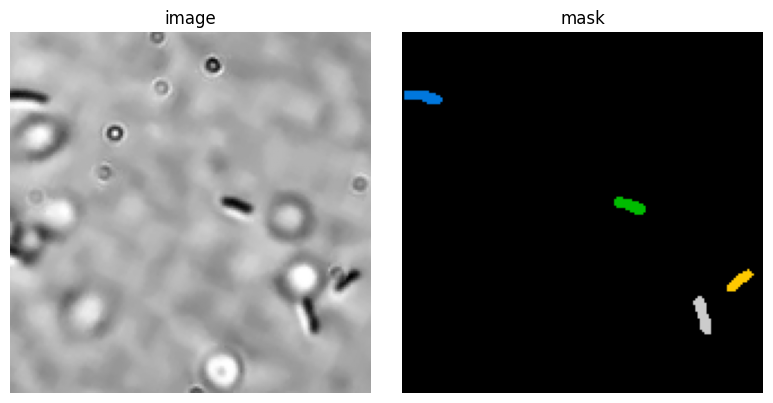

Detected 5 cells


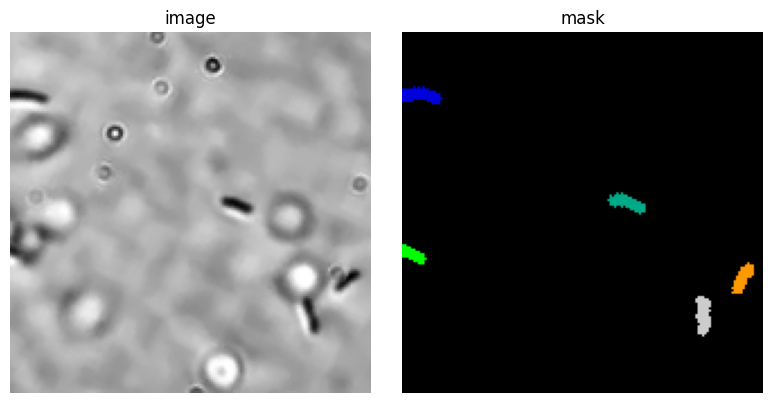

In [134]:
# Load model
pretrained_model = Path("models") / "ecoli_model.pt"
model = models.CellposeModel(gpu=True, pretrained_model=str(pretrained_model))

# Evaluate on a training image
labels, flows, styles = model.eval(
    train_images[0],
)
cell_segmenter_visualize(train_images[0], labels)
cell_segmenter_visualize(train_images[0], train_masks[0])

The result is good, but still contains some initially detected cells for the dots on the image.
This shows that we should train for much longer.

Finally, we are going to test the network's generalizing capabilities by running it on a previously unseen image.

Detected 13 cells


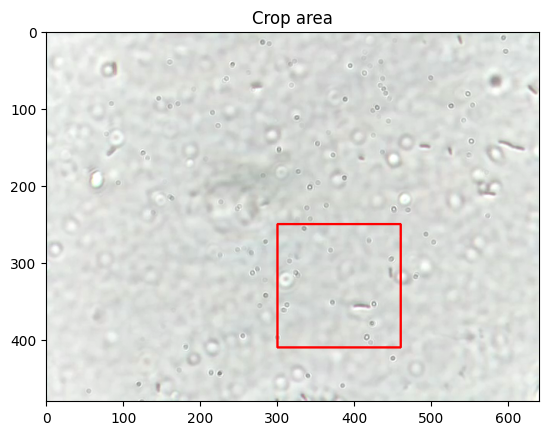

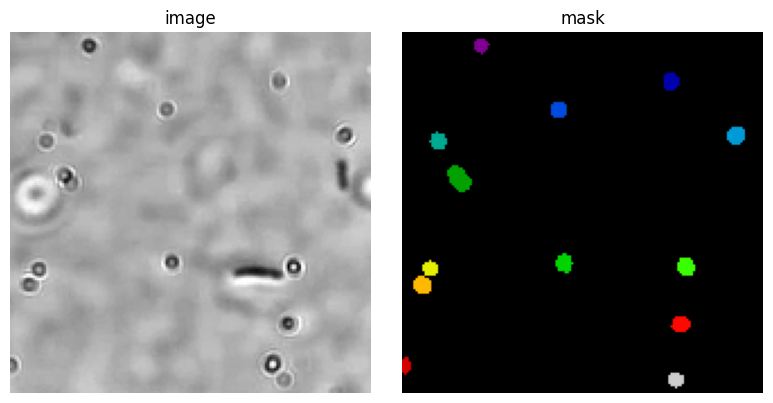

In [135]:
nr = 25  # image number to test
image = cv2.imread(ecoli_path / f"img_{nr:04d}.tif").astype(np.float32)

x_min = 300
y_min = 250
H = 32*5
W = 32*5

# Draw rectangle to show crop area
image_with_rect = image.copy()
cv2.rectangle(
    image_with_rect,
    (x_min, y_min),
    (x_min + 32*5, y_min + 32*5),
    (255, 0, 0),
    2,
)
plt.imshow(image_with_rect.astype(np.uint8))
plt.title("Crop area")

# Crop the image
transformation = A.Crop(y_min=y_min, y_max=y_min + 32*5, x_min=x_min, x_max=x_min + 32*5)
image = transformation(image=image)["image"].astype(np.float32)

# Segment the cropped image
img_normalized = gray_norm(image, max_value=99)
labels, flows, styles = model.eval(
    img_normalized,
)
cell_segmenter_visualize(img_normalized, labels)

---
**License**: © 2025 Matthias Függer and Thomas Nowak. Licensed under [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).